In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import os
from model.AE import *
np.set_printoptions(suppress=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)
v_model = wide_VAE(zDim=512, channel=[16,80,160]).to(device)
c_model = classifier(input_dim=160).to(device)
v_model_path = './model-checkpoint/AE-v-model.pt'
c_model_path = './model-checkpoint/AE-c-model.pt'
v_model.load_state_dict(torch.load(v_model_path))
c_model.load_state_dict(torch.load(c_model_path))

/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [2]:
def testtime_update_cifar_opt(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', opti = 'adam'):
    # x_adv = x_adv.detach()
    _, x_ = vae_model(x_adv)
    x_hat_adv = vae_model.re_forward(x_)
    x_copy = x_.detach().clone()
    if opti == 'adam':
        opt = optim.Adam([x_copy], lr=learning_rate)
    elif opti == 'sgd':
        opt = optim.SGD([x_copy], lr=learning_rate, momentum=0.9)
    for _ in range(num):
        # opt.zero_grad()
        if mode == 'mean':
            loss = nn.functional.mse_loss(x_hat_adv, x_adv, reduction='mean')
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
        x_.retain_grad()
        loss.backward(retain_graph=True)
        grad = torch.autograd.grad(loss, x_, allow_unused=True)
        # exit()
        with torch.no_grad():
            x_copy.grad = grad[0]
        # with torch.no_grad():
        #     x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        opt.step()
        x_ = x_copy.detach().clone()
        x_.requires_grad = True
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_)
    return logit_adv, x_hat_adv

def pgd_cifar_resnet(vae_model, c_model, X, label, num_steps, epsilon, step_size):
    X_pgd = Variable(X.data, requires_grad=True)
    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        with torch.enable_grad():
            _, z = vae_model(X_pgd)
            logit = c_model(z)
            loss = nn.CrossEntropyLoss()(logit, label)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
    return X_pgd

In [3]:
def test(vae_model, c_model, channel=128, lr=0.01, num=50):
    err_num = 0
    err_adv = 0
    err_nat = 0
    c_model.eval()
    vae_model.eval()
    f = True
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,x_ = vae_model(data)
        logit = c_model(x_)
        err_nat += (logit.data.max(1)[1] != target.data).float().sum()
        logit_new, data_new = testtime_update_cifar_opt(vae_model, c_model, data, target,learning_rate=lr, num=num, opti='adam')
        # logit_new = testtime_update_cifar(vae_model, c_model, data, target,learning_rate=0.1, num=100, channel=channel)
        # label = logit_calculate(logit, logit_new).to(device)
        # err_num += (label.data != target.data).float().sum()
        x_adv = pgd_cifar_resnet(vae_model, c_model, data, target, 20, 0.03, 0.003)
        # x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        _,x_ = vae_model(x_adv)
        logit_adv = c_model(x_)
        logit_adv_new, data_adv_new = testtime_update_cifar_opt(vae_model, c_model, x_adv, target,learning_rate=lr, num=num, opti='adam')
        # logit_adv_new = testtime_update_cifar(vae_model, c_model, x_adv, target,learning_rate=0.1, num=100, channel=channel)
        if f:
            return logit, logit_adv, logit_new, logit_adv_new, target, data, data_new, x_adv, data_adv_new
        # label_adv = logit_calculate(logit_adv, logit_adv_new).to(device)
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=100)
        # _,_,_,x_ = vae_model(x_adv)
        # logit_adv = c_model(x_.view(-1,160,8,8))
        # err_adv += (label_adv.data != target.data).float().sum()
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_nat)
    print(err_num)
    print(err_adv)

In [4]:
def logit_calculate(logit_old, logit_new):
    label_old = logit_old.data.max(1)[1]
    label_new = logit_new.data.max(1)[1]
    logit_diff = logit_new - logit_old
    label_diff = logit_diff.data.max(1)[1]
    label_update = []
    return label_diff
    for i in range(label_old.size(0)):
        # if logit_diff[i][label_old[i]].item() / abs(logit_old[i][label_old[i]].item()) >= -0.1:
        if logit_diff[i][label_old[i]] < -2.0:
        # if logit_diff[i][label_old[i]] < -2.0 and logit_diff.data.max(1)[0][i]/torch.abs(logit_diff[i][label_old[i]]) > 0.8:
            label_update.append(label_diff[i].item())
        else:
            label_update.append(label_new[i].item())
    return torch.Tensor(label_update)

In [5]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [6]:
for d, _ in test_loader:
    d = d.to(device)
    break
x_,_=v_model(d)

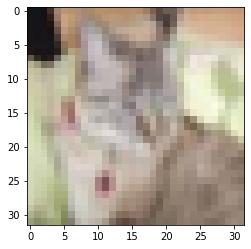

In [7]:
idx = 8
show_image(d, idx=idx)

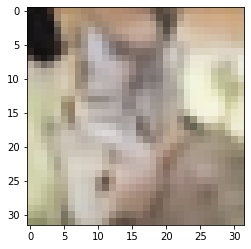

In [8]:
show_image(x_, idx = idx)

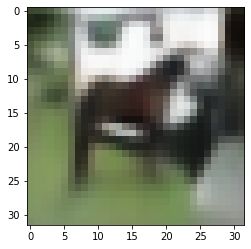

In [13]:
show_image(x_adv_new, idx = idx)

In [12]:
logit, logit_adv,logit_nat_new, logit_adv_new, target,x,x_new,x_adv,x_adv_new = test(v_model, c_model, channel=160, lr=0.05, num=300)

In [16]:
label = logit_calculate(logit_adv, logit_adv_new)
# label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())
# print([i for i in range(200) if label[i]==target[i]])

tensor(12, device='cuda:0')
tensor(156, device='cuda:0')


In [31]:
idx = 20
print(target[idx])
print(logit[idx])
print(logit_nat_new[idx])

tensor(7, device='cuda:0')
tensor([-20.4150, -14.0684, -19.6838,  -2.1771,  -1.9325,  -1.7247, -10.8600,
          4.7810, -14.1253, -15.9275], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-19.3551, -12.2616, -19.2976,  -4.3622,  -1.5895,  -3.6915,  -9.2636,
          3.5605, -10.8009, -14.3512], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [32]:
print(logit_adv[idx])
print(logit_adv_new[idx])

tensor([-23.8594, -23.3612, -16.8273,   2.7087,  -4.4518,  20.5940, -17.0873,
        -19.6063, -26.2734, -25.1594], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-21.3448, -20.7548, -15.3283,   0.0370,  -2.4992,  17.2300, -15.0408,
        -17.9367, -22.4219, -21.6271], device='cuda:0',
       grad_fn=<SelectBackward0>)


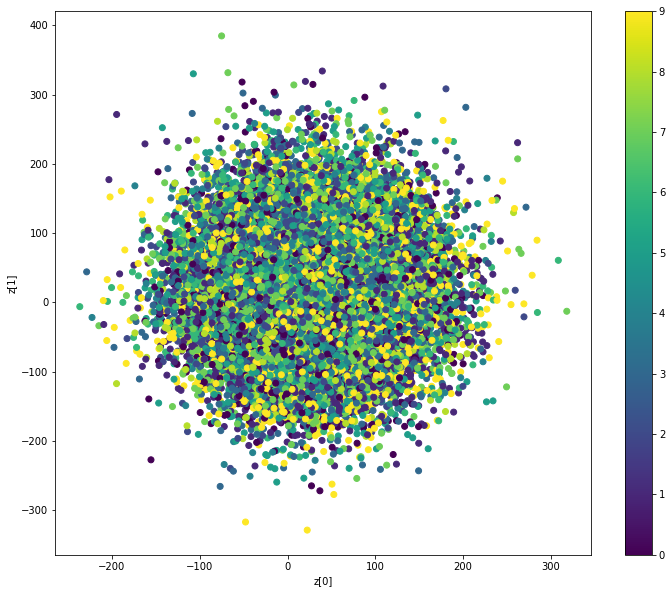

In [49]:
import matplotlib.pyplot as plt
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(VAE, train_loader):
    plt.figure(figsize=(12, 10))
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        z_mean, _ = VAE.encoder(data)
        plt.scatter(z_mean.cpu().detach().numpy()[:, 0], z_mean.cpu().detach().numpy()[:, 1], c=labels.cpu().detach().numpy())
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.colorbar()
    plt.show()


plot_label_clusters(v_model, train_loader)